In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, i_nc, n_fs):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(i_nc, n_fs, kernel_size=7, padding=3, stride=1, bias=False)
        self.conv2 = nn.Conv1d(n_fs, n_fs, kernel_size=5, padding=2, stride=1, bias=False)
        self.conv3 = nn.Conv1d(n_fs, n_fs, kernel_size=3, padding=1, stride=1, bias=False)

        if i_nc == n_fs:
            self.shortcut = None
        else:
            self.shortcut = nn.Conv1d(i_nc, n_fs, kernel_size=1, padding=0, stride=1, bias=False)
    
    def forward(self, x):
        conv_y = self.conv1(x)
        conv_y = self.conv2(conv_y)
        out = self.conv3(conv_y)
        if self.shortcut is not None:
            out = out + self.shortcut(x)
        else:
            out = out + x
        return out

class ResNet_TSC(nn.Module):
    
    def __init__(self, nc_input, n_classes):
        super(ResNet_TSC, self).__init__()
        n_fs = 64

        self.block1 = ResidualBlock(nc_input, n_fs)
        self.block2 = ResidualBlock(n_fs, n_fs*2)
        self.block3 = ResidualBlock(n_fs*2, n_fs*2)
        self.final = nn.Linear(n_fs*2, n_classes)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = F.adaptive_avg_pool1d(x,1)
        x = x.view(x.size(0), -1)
        x = self.final(x)
        return x

    


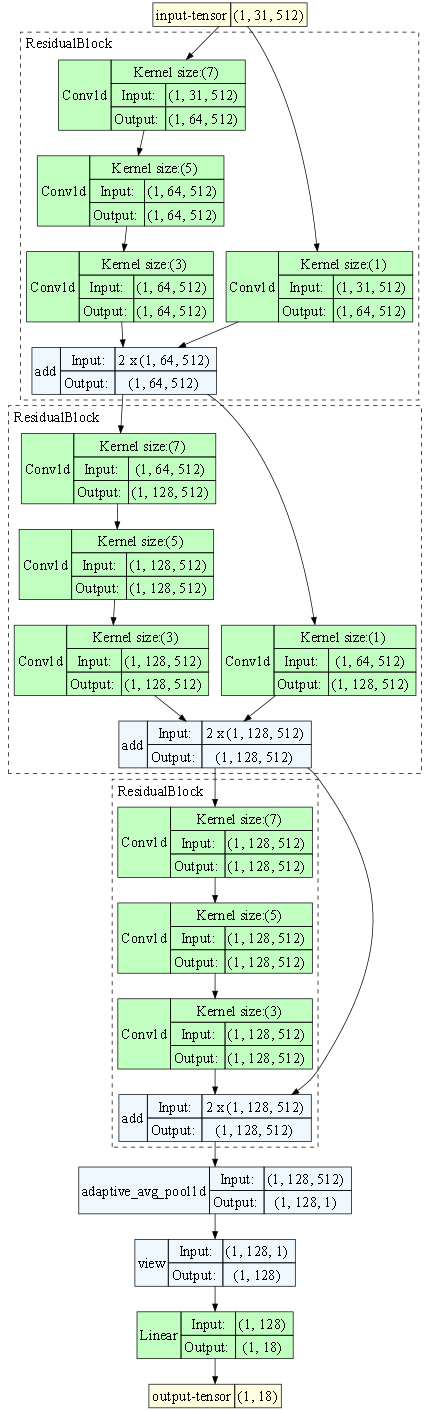

In [6]:
from utils import data_info
# import os
# os.environ["PATH"]+=os.pathsep+'C:\\Program Files\\Graphviz\\bin'
import graphviz
graphviz.set_jupyter_format('png')

#dataset = "UCI_HAR"
#dataset = "UniMiB-SHAR"
#dataset = "OPPORTUNITY"
dataset = "PAMAP2"
#dataset = "DSADS"
#dataset = "KU-HAR"
#dataset = "REALDISP"


input_nc, segment_size, class_num = data_info(dataset)

net = ResNet_TSC(input_nc, class_num)

from torchview import draw_graph

model_graph = draw_graph(net, input_size=(1, input_nc, segment_size), expand_nested=True, save_graph=True, filename="resnet")
model_graph.visual_graph